# С помощью ключевых слов создадим маленькие выборки по event-type

## Подгрузим библиотеки, настройки графиков, пути для папок. Подгрузим файл с текстами.

In [296]:
from pandas_datareader import data
from pandas_datareader._utils import RemoteDataError
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import csv
import re
from datetime import datetime

import os.path
from os import path
import time

# import sklearn
# import scipy

# from sklearn.naive_bayes import GaussianNB
# import lightgbm as lightgbm
# from xgboost import XGBClassifier
# import keras

# Get Started
# https://github.com/Refinitiv-API-Samples/Article.EikonDataAPI.DotNet.Library
# API limits
# https://developers.refinitiv.com/en/api-catalog/eikon/eikon-data-api/documentation?content=49692&type=documentation_item
import eikon as ek 

from pylab import rcParams
plt.rcParams['figure.figsize'] = 16, 8

In [297]:
# Настройки для графиков, чтобы увеличить шрифты и размеры.
fontsize_reg = 12
fontsize_title = 16
from pylab import rcParams
rcParams['figure.facecolor'] = '1'
rcParams['figure.figsize'] = [8.0, 3.5]
rcParams['figure.dpi'] = 80
rcParams['savefig.dpi'] = 600

rcParams['font.size'] = 12
rcParams['legend.fontsize'] = 'large'
rcParams['figure.titlesize'] = 'large'

plt.rcParams['axes.axisbelow'] = True

In [578]:
# Зададим path для папки проекта и для папок файлов
path_project_folder = 'C:/DAN/t_systems/trade_project/'
folder_name_headlines = 'backup_headlines/'
folder_name_logger = 'logger/'
folder_name_for_labelling = 'for_labelling/'

In [299]:
def get_name_of_latest_file_in_folder(folder_name):
    """
    Get all file names in selected direction.
    Return the latest file in that directory.
    """
    files_creation_dates = pd.DataFrame(data = [], columns=[
        "folder_name", "file_name", "num_time", "str_time"
    ])

    files_creation_dates['file_name'] = os.listdir(folder_name)
    files_creation_dates['folder_name'] = folder_name
    files_creation_dates['file_folder_and_name'] = files_creation_dates['folder_name'] + files_creation_dates['file_name']
    files_creation_dates
    for i in range(0, len(files_creation_dates)):
        file_folder_and_name = files_creation_dates['file_folder_and_name'][i]
        files_creation_dates['num_time'][i] = os.path.getctime(file_folder_and_name)
        files_creation_dates['str_time'][i] = time.ctime(os.path.getctime(file_folder_and_name))

    latest_file_dir = files_creation_dates.sort_values(by=['num_time'], ascending=False)['file_folder_and_name'].iloc[0]
    
    return latest_file_dir

In [300]:
# Подгрузим файл, с которым будем работать.
latest_file = get_name_of_latest_file_in_folder(path_project_folder + folder_name_headlines)
all_headlines_df = pd.read_csv(latest_file, sep='~')
all_headlines_df['versionCreated'] = pd.to_datetime(all_headlines_df['versionCreated'])
print(all_headlines_df.shape, latest_file)

(178456, 6) C:/DAN/t_systems/trade_project/backup_headlines/all_headlines_df_2021-01-19_v3.csv


## Добавим столбец с языком новости. Переведём сырой HTML в читабельный текст.

In [301]:
# Чанк1 для тестирования регулярных выражений.
text_for_search = 'to 120 from 160'
re.search(r'to \d* from \d*', text_for_search, re.IGNORECASE).group() # Q3 operating profit

'to 120 from 160'

In [302]:
# Чанк2 для тестирования регулярных выражений.
print(re.search(r' lang="\w*"', str(all_headlines_df.loc[200, 'story']), re.IGNORECASE) != None, all_headlines_df.loc[200, 'story'])
print(re.search(r' lang="\w*"', str(all_headlines_df.loc[500, 'story']), re.IGNORECASE) != None)

False nan
True


### Добавим язык новости
Вытащим язык статьи и создадим отдельный столбец. Только у пропущенных пустых статей нет языка.

In [303]:
# Способ вытащить язык с помощью цикла (очень медленно).
# all_headlines_df['story_lang'] = np.nan
# for index in all_headlines_df.index:
#     story_now = all_headlines_df.loc[index, 'story']
#     try:
#         all_headlines_df.loc[index, 'story_lang'] = re.findall(r' lang="(.*)"', story_now)[0].split('"')[0]
#     except Exception as e:
#         print(index, e, story_now, end=' ')

In [304]:
# Лучше воспользоваться lambda функциями.
def search_pattern_by_rule(rule, text_for_search):
    """Is that pattern matches with selected text. Return boolean"""
    return re.search(rule, text_for_search, re.IGNORECASE) != None

def findall_by_rule(rule, text_for_search):
    """
    If that pattern matches with selected text, then returns 
    """
    if re.search(rule, str(text_for_search), re.IGNORECASE) != None:
        result = re.findall(rule, text_for_search)
    else:
        result = ['no result']
    return result[0].split('"')[0]

all_headlines_df['story_lang'] = all_headlines_df['story'].apply(lambda x: findall_by_rule(rule=r' lang="(.*)"', text_for_search=x))

# Какие языки у нас есть в новостях.
top_languages = all_headlines_df.groupby(by='story_lang').agg(
    story_count=('storyId', 'count')
).sort_values(by='story_count', ascending=False)
print(list(top_languages.index))

['en', 'de', 'es', 'fr', 'pt', 'zh', 'ja', 'no result', 'it', 'ru', 'ar', 'cs', 'tr', 'ko', 'pl', 'th', 'vi', 'id', 'nl', 'ms', 'hu', 'el', 'sv', 'no', 'fi', 'da']


Text(0.5, 1.0, 'Number of stories per language')

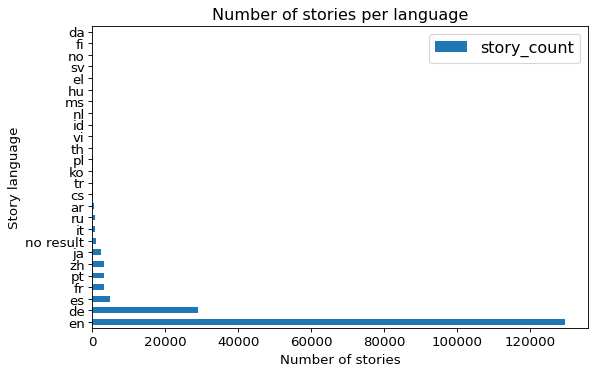

In [305]:
top_languages.plot(kind='barh', figsize=(8,5))
plt.xlabel('Number of stories')
plt.ylabel('Story language')
plt.title('Number of stories per language')

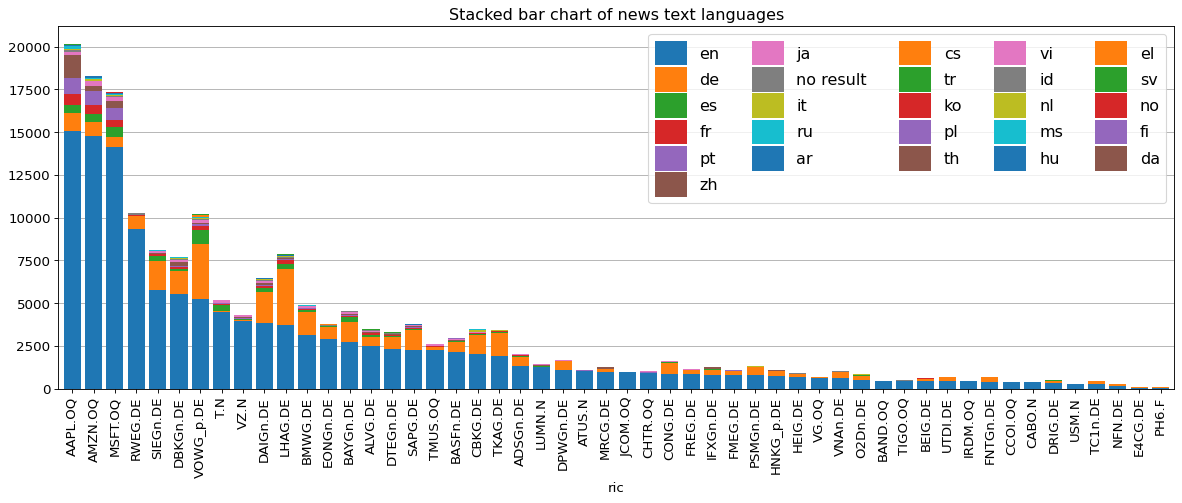

In [306]:
# Посчитаем groupby таблицу, чтобы потом построить pivot для stacked bar chart
for_pivot_groupby_ric_lang = all_headlines_df.groupby(by=['ric', 'story_lang']).agg(
    story_count=('storyId', 'count'))

# Вытащим из индекса столбцы
for_pivot_groupby_ric_lang[for_pivot_groupby_ric_lang.index.names[0]] = for_pivot_groupby_ric_lang.index.get_level_values(0)
for_pivot_groupby_ric_lang[for_pivot_groupby_ric_lang.index.names[1]] = for_pivot_groupby_ric_lang.index.get_level_values(1)

# 
pivot_ric_lang = for_pivot_groupby_ric_lang.pivot(index='ric', columns='story_lang', values='story_count')
pivot_ric_lang = pivot_ric_lang[top_languages.index]
pivot_ric_lang = pivot_ric_lang.sort_values(by='en', ascending=False)

pivot_ric_lang.plot.bar(stacked=True, width=0.8, figsize=(18,6))
plt.legend(loc='upper right', ncol=5, handleheight=2, labelspacing=0.1)
plt.title('Stacked bar chart of news text languages')
plt.grid(True, axis='y')

### Переконвертируем сырой HTML формат в читаемый текст.

In [307]:
# Переконвертируем сырой HTML формат в читаемый текст.
from bs4 import BeautifulSoup

print(datetime.now().strftime("%d/%m/%Y %H:%M:%S"))

all_headlines_df['story'] = all_headlines_df['story'].apply(str)
all_headlines_df['story_wo_html'] = all_headlines_df['story'].apply(lambda x: BeautifulSoup(x, 'lxml').get_text())

print()    
print(datetime.now().strftime("%d/%m/%Y %H:%M:%S"))

## Найдём ключевые фразы в текстах новостей

In [317]:
# Подгрузим правила для обнаружения паттернов из экселя.
key_words_excel = pd.read_excel(path_project_folder + 'key_words.xlsx')
print(key_words_excel.shape)
key_words_excel.head(2)

(19, 12)


,event-types,from article,key_word_1,key_word_2,key_word_3,key_word_4,key_word_5,key_word_6,key_word_7,key_word_8,key_word_9,key_word_10
0,Financial Results,1,announces(\s*)(Q1|Q2|Q3|Q4).*result,(Q1|Q2|Q3|Q4)[\s*]operating profit,(Q1|Q2|Q3|Q4)[\s*]sales,Announces[\s*](First|Second|Third|Fourth)[\s*]...,Earnings Preview,expected to report,quarterly revenue,NaN,NaN,NaN
1,Product Update,1,announced.*product,(becomes|became|become) available,next generation of,present new product,offer new product,inovat.*product,NaN,NaN,NaN,NaN


In [319]:
# Создадим списки колонок (cols_key_words) и списки типов событий (event_types_list).
# Они нужны лишь для создания col_names_and_rules_key_words.
cols_key_words = [
    'key_word_1', 'key_word_2', 'key_word_3', 'key_word_4', 'key_word_5', 
    'key_word_6', 'key_word_7', 'key_word_8', 'key_word_9', 'key_word_10']
event_types_list = list(key_words_excel['event-types'])
print(len(event_types_list), event_types_list)

19 ['Financial Results', 'Product Update', 'Collaboration', 'Merger and Acquisition', 'Contract - Agreement - Deal', 'Dividend', 'Investment', 'Asset Sale', 'Lawsuit', 'Settlement', 'Stock Buyback', 'Executive Change', 'Credit Debt Rating', 'Analyst Rating', 'Price Target', 'Workforce Change', 'Investigation', 'Eco Issues', 'Security Protection']


In [320]:
# Создадим df, который будет содержать список правил для обнаружения фраз.
col_names_and_rules_key_words = pd.DataFrame(data = [], columns=["event_type", "rule_name", "rule"])

for event_type_now in event_types_list:
    for i in range(0, len(cols_key_words)):
        # Вытащим одно из десяти правил для данного типа событий
        key_word_now = str(key_words_excel[key_words_excel['event-types'] == event_type_now][cols_key_words[i]].iloc[0])
        if key_word_now != 'nan':
            key_word_now_cleaned = re.sub('[^a-zA-Z0-9 \n]', '_', key_word_now).replace(' ', '_')
            col_names_and_rules_key_words = col_names_and_rules_key_words.append({
                "event_type": str(event_type_now).replace(' ', '_'),
                "rule_name": str(key_word_now_cleaned),
                "rule": str(key_word_now)
            }, ignore_index = True)
            # print(event_type_now, i, key_word_now, key_word_now_cleaned)
        else:
            # print(event_type_now, i, '!!!NAN!!!')
            pass

# Добавим столбец с полным названием столбцов для key_words_detection_df.
# Эти столбцы будут означать об обнаружении паттерна данного правила.
col_names_and_rules_key_words['full_col_name'] = col_names_and_rules_key_words['event_type'] + '_' + col_names_and_rules_key_words['rule_name']

# Создадим ещё один список событий на осноце col_names_and_rules_key_words
# Если для какого-то типа событий не было правил (они все nan),
# то такой тип событий не будет включён в event_types_list.
event_types_list_after_loop = list(col_names_and_rules_key_words.groupby('event_type').agg('count').index)
print(len(event_types_list_after_loop), event_types_list_after_loop)

19 ['Analyst_Rating', 'Asset_Sale', 'Collaboration', 'Contract_-_Agreement_-_Deal', 'Credit_Debt_Rating', 'Dividend', 'Eco_Issues', 'Executive_Change', 'Financial_Results', 'Investigation', 'Investment', 'Lawsuit', 'Merger_and_Acquisition', 'Price_Target', 'Product_Update', 'Security_Protection', 'Settlement', 'Stock_Buyback', 'Workforce_Change']


In [321]:
col_names_and_rules_key_words

,event_type,rule_name,rule,full_col_name
0,Financial_Results,announces__s___Q1_Q2_Q3_Q4___result,announces(\s*)(Q1|Q2|Q3|Q4).*result,Financial_Results_announces__s___Q1_Q2_Q3_Q4__...
1,Financial_Results,_Q1_Q2_Q3_Q4___s__operating_profit,(Q1|Q2|Q3|Q4)[\s*]operating profit,Financial_Results__Q1_Q2_Q3_Q4___s__operating_...
2,Financial_Results,_Q1_Q2_Q3_Q4___s__sales,(Q1|Q2|Q3|Q4)[\s*]sales,Financial_Results__Q1_Q2_Q3_Q4___s__sales
3,Financial_Results,Announces__s___First_Second_Third_Fourth___s__...,Announces[\s*](First|Second|Third|Fourth)[\s*]...,Financial_Results_Announces__s___First_Second_...
4,Financial_Results,Earnings_Preview,Earnings Preview,Financial_Results_Earnings_Preview
...,...,...,...,...
97,Security_Protection,smartphone_security,smartphone security,Security_Protection_smartphone_security
98,Security_Protection,authentication,authentication,Security_Protection_authentication
99,Security_Protection,hardware_attack,hardware attack,Security_Protection_hardware_attack
100,Security_Protection,verify_their_identity,verify their identity,Security_Protection_verify_their_identity


In [322]:
# Создадим df, который будет содержать информацию об обнаружении ключевых фраз.
key_words_detection_df = all_headlines_df[['ric', 'versionCreated', 'headline', 'storyId', 'sourceCode', 'story_wo_html', 'story_lang']]
print(key_words_detection_df.shape)
key_words_detection_df.head(2)

(178456, 7)


,ric,versionCreated,headline,storyId,sourceCode,story_wo_html,story_lang
0,DTEGn.DE,2020-12-23 18:25:27.865000+00:00,IGN Igen Networks joins T-Mobile partner program,urn:newsml:reuters.com:20201223:nNRAdspppv:1,NS:CNSWCH,Igen Networks Corp. has joined the T-Mobile pa...,en
1,DTEGn.DE,2020-12-22 08:35:59.285000+00:00,(EN) Makedonski Telekom AD - Skopje Board Chan...,urn:newsml:reuters.com:20201222:nGLF4Kt1L3:2,NS:GLFILE,http://filings.ica.int.thomsonreuters.com/fili...,en


In [323]:
# Лишнее действие
# Создадим пустые колонки, куда будем записывать результат метчинга.
# print(key_words_detection_df.shape)
# for index, row in col_names_and_rules_key_words.iterrows():
#     column_now = str(row['full_col_name'])
#     key_words_detection_df[column_now] = np.nan
#     print(column_now, end=' ')
# print()
# print(key_words_detection_df.shape)

In [324]:
# Тупой цикл, через lambda быстрее
# story_now = key_words_detection_df.loc[i, 'story_wo_html']
# story_now
# i = 100
# for index, row in col_names_and_rules_key_words.iterrows():
#     column_now = str(row['event_type']) + '_' + str(row['rule_name'])
#     is_found_by_rule = re.search(row['rule'], story_now, re.IGNORECASE) != None
#     key_words_detection_df.loc[i, column_now] = is_found_by_rule

In [315]:
# Разметим, где был найден паттерн, а где нет
def search_pattern_by_rule(rule, text_for_search):
    return re.search(rule, text_for_search, re.IGNORECASE) != None

print(datetime.now().strftime("%d/%m/%Y %H:%M:%S"))

for index, row in col_names_and_rules_key_words.iterrows():
    column_now = str(row['full_col_name'])
    rule_now = row['rule']
    key_words_detection_df[column_now] = key_words_detection_df['story_wo_html'].apply(lambda x: search_pattern_by_rule(rule_now, x))
    print(index, end=' ')
    
print()    
print(datetime.now().strftime("%d/%m/%Y %H:%M:%S"))

19/01/2021 12:27:34
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 
19/01/2021 12:36:48


In [316]:
# Сохраним на всяикй случай файл с обнаружением правил.
# Для сохранения успешного сохранения файла переведём дату в текст,
# а затем снова в datetime формат.
print(datetime.now().strftime("%d/%m/%Y %H:%M:%S"))
key_words_detection_df['versionCreated'] = key_words_detection_df['versionCreated'].astype(str)
key_words_detection_df.to_csv(path_project_folder + "key_words_detection_df.csv", index=False)
key_words_detection_df['versionCreated'] = pd.to_datetime(key_words_detection_df['versionCreated'])
print(datetime.now().strftime("%d/%m/%Y %H:%M:%S"))

19/01/2021 12:36:48
19/01/2021 12:36:59


In [330]:
# Може подгрузить csv, если хотим откатиться и не пересчитывать
# key_words_detection_df = pd.read_csv(path_project_folder + "key_words_detection_df.csv")

In [38]:
# уже не актуально
# Для возможности посчитать сумму по столбцам переведём формат в integer
# key_words_detection_df[
#     list(col_names_and_rules_key_words['full_col_name'])
# ] = key_words_detection_df[
#     list(col_names_and_rules_key_words['full_col_name'])
# ].astype(int)

In [455]:
cols_totals_match_count = []

for event_type_now in event_types_list_after_loop:
    cols_now = list(col_names_and_rules_key_words[col_names_and_rules_key_words['event_type'] == event_type_now]['full_col_name'])
    new_col_name = str(event_type_now)
    cols_totals_match_count.append(new_col_name)
    key_words_detection_df[new_col_name] = key_words_detection_df[cols_now].sum(axis=1)
    
print(cols_totals_match_count)

['Analyst_Rating', 'Asset_Sale', 'Collaboration', 'Contract_-_Agreement_-_Deal', 'Credit_Debt_Rating', 'Dividend', 'Eco_Issues', 'Executive_Change', 'Financial_Results', 'Investigation', 'Investment', 'Lawsuit', 'Merger_and_Acquisition', 'Price_Target', 'Product_Update', 'Security_Protection', 'Settlement', 'Stock_Buyback', 'Workforce_Change']


['Analyst_Rating', 'Asset_Sale', 'Collaboration', 'Contract_-_Agreement_-_Deal', 'Credit_Debt_Rating', 'Dividend', 'Eco_Issues', 'Executive_Change', 'Financial_Results', 'Investigation', 'Investment', 'Lawsuit', 'Merger_and_Acquisition', 'Price_Target', 'Product_Update', 'Security_Protection', 'Settlement', 'Stock_Buyback', 'Workforce_Change']


Text(0.5, 1.0, 'How many event-types are detected for each news text')

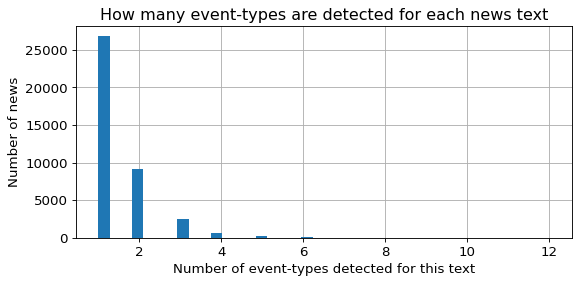

In [456]:
# Для того, чтобы посчитать количество типов событий, к которым отнесли текст,
# переконвертируем в boolean формат, чтобы можно было считать не как
# количество обнаруженных правил, а количество типов событий.
# А затем снова пересчитаем эти столбцы

key_words_detection_df[cols_totals_match_count] = key_words_detection_df[
    cols_totals_match_count
].astype(bool)
# Подсчитаем именно количество типов событий
key_words_detection_df['number_of_types_detected'] = key_words_detection_df[event_types_list_after_loop].sum(axis=1)

# Пересчитаем как количество упоминаний
cols_totals_match_count = []
for event_type_now in event_types_list_after_loop:
    cols_now = list(col_names_and_rules_key_words[col_names_and_rules_key_words['event_type'] == event_type_now]['full_col_name'])
    new_col_name = str(event_type_now)
    cols_totals_match_count.append(new_col_name)
    key_words_detection_df[new_col_name] = key_words_detection_df[cols_now].sum(axis=1)
print(cols_totals_match_count)

key_words_detection_df[key_words_detection_df['number_of_types_detected'] > 0]['number_of_types_detected'].hist(bins=40)
plt.xlabel('Number of event-types detected for this text')
plt.ylabel('Number of news')
plt.title('How many event-types are detected for each news text')

## Посмотрим на количество обнаруженных статей

In [88]:
# Как выглядят столбцы с итоговыми значенями обнаруженных паттернов
key_words_detection_df[cols_totals_match_count]

,Analyst_Rating,Asset_Sale,Collaboration,Contract_-_Agreement_-_Deal,Credit_Debt_Rating,Dividend,Eco_Issues,Executive_Change,Financial_Results,Investigation,Investment,Lawsuit,Merger_and_Acquisition,Price_Target,Product_Update,Security_Protection,Settlement,Stock_Buyback,Workforce_Change
0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168553,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
168554,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
168555,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
168556,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0


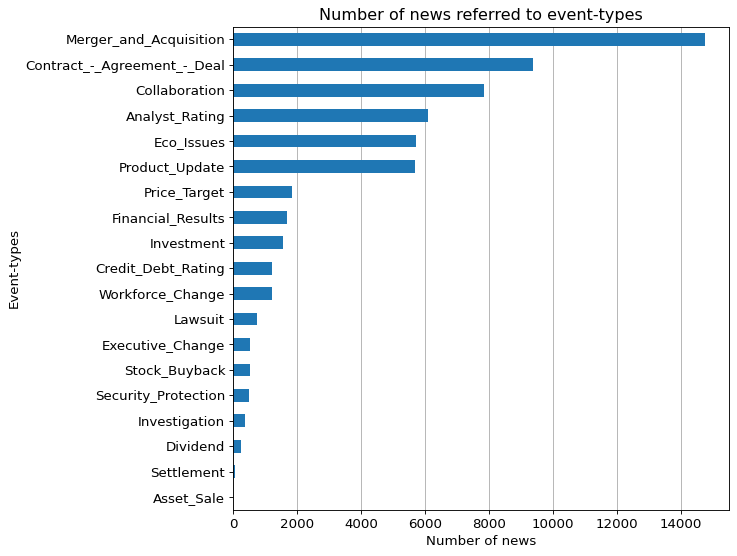

In [83]:
key_words_detection_df[cols_totals_match_count].sum().sort_values(ascending=True).plot.barh(figsize=(8,8))
plt.xlabel('Number of news')
plt.ylabel('Event-types')
plt.title('Number of news referred to event-types')
plt.grid(True, axis='x')

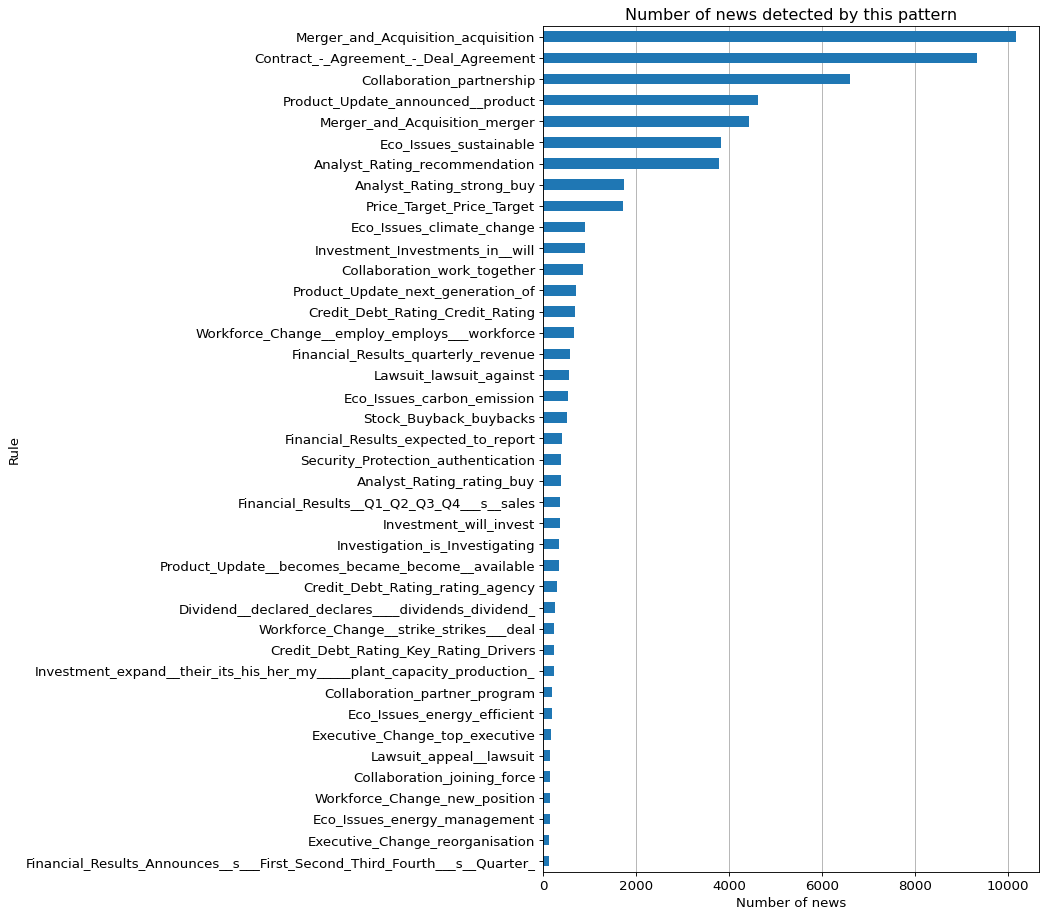

In [84]:
key_words_detection_df[col_names_and_rules_key_words['full_col_name']].sum().sort_values(ascending=True).tail(40).plot.barh(figsize=(8,14))
plt.xlabel('Number of news')
plt.ylabel('Rule')
plt.title('Number of news detected by this pattern')
plt.grid(True, axis='x')

## Посмотрим на корреляции между типами новостей и между правилами паттернов

In [89]:
print('Correlations of event-types')
corr = key_words_detection_df[cols_totals_match_count].corr()
corr.style.background_gradient(vmin = -0.5, vmax = 0.5, cmap='seismic')

Correlations of event-types


,Analyst_Rating,Asset_Sale,Collaboration,Contract_-_Agreement_-_Deal,Credit_Debt_Rating,Dividend,Eco_Issues,Executive_Change,Financial_Results,Investigation,Investment,Lawsuit,Merger_and_Acquisition,Price_Target,Product_Update,Security_Protection,Settlement,Stock_Buyback,Workforce_Change
Analyst_Rating,1.000000,-0.000635,0.043171,0.027414,0.147194,0.005432,0.034341,0.002067,0.182617,0.004517,0.105590,0.003152,0.048399,0.246661,0.054083,0.013397,-0.002195,0.036915,0.021826
Asset_Sale,-0.000635,1.000000,0.005393,0.011248,-0.000254,-0.000166,-0.000674,-0.000228,-0.000386,-0.000189,-0.000391,-0.000262,0.016504,-0.000430,-0.000759,-0.000220,-0.000061,-0.000232,-0.000348
Collaboration,0.043171,0.005393,1.000000,0.156635,0.005570,0.011374,0.189733,0.008299,0.002840,-0.004099,0.069170,-0.001410,0.042865,-0.006053,0.204851,0.036444,-0.003031,0.006254,0.047512
Contract_-_Agreement_-_Deal,0.027414,0.011248,0.156635,1.000000,0.032936,0.016194,0.139846,0.019345,0.008488,0.023994,0.073627,0.026734,0.161120,-0.001382,0.094290,0.004586,0.016198,0.016146,0.058495
Credit_Debt_Rating,0.147194,-0.000254,0.005570,0.032936,1.000000,0.011325,0.039941,0.021897,0.006610,0.006010,0.008075,0.003121,0.082829,-0.002002,0.007153,-0.001426,-0.000876,0.049675,0.002364
Dividend,0.005432,-0.000166,0.011374,0.016194,0.011325,1.000000,0.004423,0.008256,0.108866,0.001231,0.022005,0.012418,0.024314,0.030074,0.027599,0.003248,-0.000573,0.008772,0.010702
Eco_Issues,0.034341,-0.000674,0.189733,0.139846,0.039941,0.004423,1.000000,0.030297,0.007501,0.010581,0.106732,0.003440,0.040266,0.004487,0.130885,0.010801,-0.002327,0.021585,0.045573
Executive_Change,0.002067,-0.000228,0.008299,0.019345,0.021897,0.008256,0.030297,1.000000,0.001609,0.001612,0.034626,0.006655,0.024796,-0.000721,0.023958,0.002537,-0.000786,0.004395,0.057758
Financial_Results,0.182617,-0.000386,0.002840,0.008488,0.006610,0.108866,0.007501,0.001609,1.000000,-0.001949,0.036656,0.002731,0.050454,0.117608,0.024804,-0.001911,-0.001333,0.018613,0.018842
Investigation,0.004517,-0.000189,-0.004099,0.023994,0.006010,0.001231,0.010581,0.001612,-0.001949,1.000000,0.016959,0.018674,0.027886,-0.003476,0.008849,0.012083,0.113874,0.006033,-0.000991


In [90]:
# Зададим функции, чтобы создавать попарные таблицы с корреляциями
# https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

In [91]:
print('EVENT-TYPES CORRELATIONS')
print("Top Absolute Correlations")
get_top_abs_correlations(key_words_detection_df[cols_totals_match_count], n=20)

EVENT-TYPES CORRELATIONS
Top Absolute Correlations


Analyst_Rating               Price_Target                   0.246661
Collaboration                Product_Update                 0.204851
                             Eco_Issues                     0.189733
Analyst_Rating               Financial_Results              0.182617
Contract_-_Agreement_-_Deal  Merger_and_Acquisition         0.161120
Collaboration                Contract_-_Agreement_-_Deal    0.156635
Analyst_Rating               Credit_Debt_Rating             0.147194
Contract_-_Agreement_-_Deal  Eco_Issues                     0.139846
Eco_Issues                   Product_Update                 0.130885
Financial_Results            Price_Target                   0.117608
Investigation                Settlement                     0.113874
Dividend                     Financial_Results              0.108866
Eco_Issues                   Investment                     0.106732
Analyst_Rating               Investment                     0.105590
Investment                   Produ

In [92]:
print('KEY WORDS CORRELATIONS')
print("Top Absolute Correlations")
get_top_abs_correlations(key_words_detection_df[col_names_and_rules_key_words['full_col_name']], n=30)

KEY WORDS CORRELATIONS
Top Absolute Correlations


Workforce_Change_collective_contract__workers               Workforce_Change_new_collective_contract                                  0.866023
Settlement_negotiated_settlement                            Settlement_settlement_package                                             0.717124
Security_Protection_smartphone_security                     Security_Protection_hardware_attack                                       0.707105
Analyst_Rating_recommendation                               Analyst_Rating_strong_buy                                                 0.617728
Credit_Debt_Rating_Credit_Rating                            Credit_Debt_Rating_Key_Rating_Drivers                                     0.566774
                                                            Credit_Debt_Rating_rating_agency                                          0.472620
Credit_Debt_Rating_Key_Rating_Drivers                       Credit_Debt_Rating_rating_agency                                          0.463695

## Попробуем посмотреть на кластеризацию статей на основе правил
Ожидалось, что при создании 19 кластеров они повторят event-types

In [96]:
from sklearn.cluster import KMeans
df = key_words_detection_df[col_names_and_rules_key_words['full_col_name']]
kmeans = KMeans(n_clusters=19, n_init = 300)
kmeans.fit(df)
labels = kmeans.predict(df)
centroids = kmeans.cluster_centers_

In [97]:
df['clust']=labels
df_means = df.groupby('clust').agg('mean')

c:\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


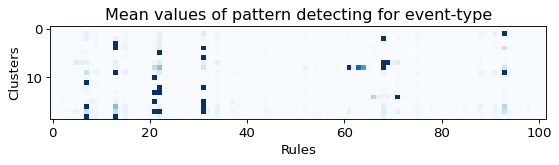

In [172]:
plt.imshow(df_means.to_numpy(), cmap='Blues', interpolation='nearest')
plt.xlabel('Rules')
plt.ylabel('Clusters')
plt.title('Mean values of pattern detecting for event-type')
plt.show()

## Распределение количества типов событий у одной новости

Text(0.5, 1.0, 'How many event-types are detected for each news text')

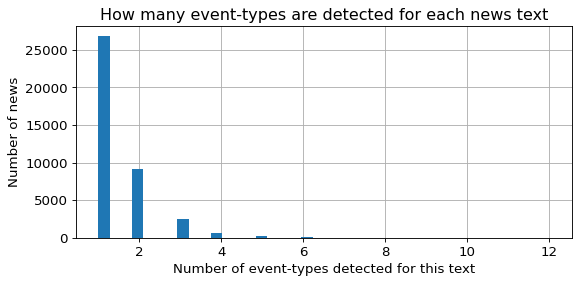

In [357]:
key_words_detection_df[key_words_detection_df['number_of_types_detected'] > 0]['number_of_types_detected'].hist(bins=40)
plt.xlabel('Number of event-types detected for this text')
plt.ylabel('Number of news')
plt.title('How many event-types are detected for each news text')

In [360]:
key_words_detection_df

,ric,versionCreated,headline,storyId,sourceCode,story_wo_html,story_lang,Financial_Results_announces__s___Q1_Q2_Q3_Q4___result,Financial_Results__Q1_Q2_Q3_Q4___s__operating_profit,Financial_Results__Q1_Q2_Q3_Q4___s__sales,...,Investment,Lawsuit,Merger_and_Acquisition,Price_Target,Product_Update,Security_Protection,Settlement,Stock_Buyback,Workforce_Change,number_of_types_detected
0,DTEGn.DE,2020-12-23 18:25:27.865000+00:00,IGN Igen Networks joins T-Mobile partner program,urn:newsml:reuters.com:20201223:nNRAdspppv:1,NS:CNSWCH,Igen Networks Corp. has joined the T-Mobile pa...,en,False,False,False,...,0,0,0,0,0,0,0,0,0,1
1,DTEGn.DE,2020-12-22 08:35:59.285000+00:00,(EN) Makedonski Telekom AD - Skopje Board Chan...,urn:newsml:reuters.com:20201222:nGLF4Kt1L3:2,NS:GLFILE,http://filings.ica.int.thomsonreuters.com/fili...,en,False,False,False,...,0,0,0,0,0,0,0,0,0,0
2,DTEGn.DE,2020-12-22 08:35:53.014000+00:00,(EN) Makedonski Telekom AD - Skopje Board Chan...,urn:newsml:reuters.com:20201222:nGLF2DBhZz:2,NS:GLFILE,http://filings.ica.int.thomsonreuters.com/fili...,en,False,False,False,...,0,0,0,0,0,0,0,0,0,0
3,DTEGn.DE,2020-12-21 13:08:03.993000+00:00,"WFB (Bus), Anyone? T-Mobile Turns Red Rose Tra...",urn:newsml:reuters.com:20201221:nBw3VPZ4Qa:1,NS:BSW,"\nWFB (Bus), Anyone? T-Mobile Turns Red Rose T...",en,False,False,False,...,0,0,0,0,0,0,0,0,0,1
4,DTEGn.DE,2020-12-19 09:00:00+00:00,HINTERGRUND-Internet überall dank Satellit und...,urn:newsml:reuters.com:20201219:nL8N2IY3D9:1,NS:RTRS,Wiederholung vom FreitagBundesnetzagentur gibt...,de,False,False,False,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178451,AMZN.OQ,2020-01-31 17:46:14+00:00,Normas tributarias globales serán revisadas en...,urn:newsml:reuters.com:20200131:nL1N2A00VA:1,NS:RTRS,"Por Leigh ThomasPARÍS, 31 ene (Reuters) - Las ...",es,False,False,False,...,0,0,0,0,0,0,0,0,0,0
178452,AMZN.OQ,2020-01-31 17:44:57.421000+00:00,"Licence Administration Of Microsoft, Amazon, G...",urn:newsml:reuters.com:20200131:nNRAaufiux:1,NS:ECLCTA,Contract award notice:Licence administration o...,en,False,False,False,...,0,0,0,0,0,0,0,0,0,0
178453,AMZN.OQ,2020-01-31 17:44:43.561000+00:00,Reuters Insider - How StockX built a $1 billio...,urn:newsml:reuters.com:20200131:nRTV2WJqfS:6,NS:CNBC,Click the following link to watch video: https...,en,False,False,False,...,0,0,0,0,0,0,0,0,0,0
178454,AMZN.OQ,2020-01-31 17:30:56+00:00,"BUZZ-U.S. STOCKS ON THE MOVE-Amazon, Marathon ...",urn:newsml:reuters.com:20200131:nL4N2A04RE:1,NS:RTRS,Eikon search string for individual stock moves...,en,False,False,False,...,0,0,0,0,0,0,0,0,0,0


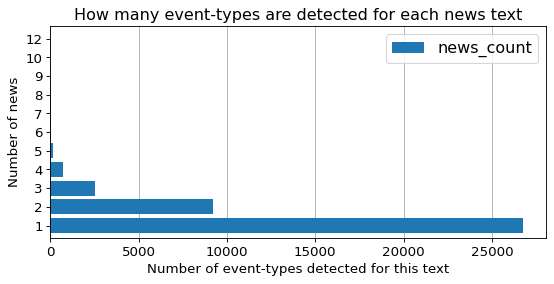

In [554]:
key_words_detection_df[
    (key_words_detection_df['number_of_types_detected'] > 0)
].groupby(by='number_of_types_detected').agg(
    news_count = ('storyId', 'count')
).plot(kind='barh', width=0.8)
plt.xlabel('Number of event-types detected for this text')
plt.ylabel('Number of news')
plt.title('How many event-types are detected for each news text')
plt.grid(True, axis='x')

nrows_plot: 5 ncols_plot: 4
0 0 0 ;  1 0 1 ;  2 0 2 ;  3 0 3 ;  4 1 0 ;  5 1 1 ;  6 1 2 ;  7 1 3 ;  8 2 0 ;  9 2 1 ;  10 2 2 ;  11 2 3 ;  12 3 0 ;  13 3 1 ;  14 3 2 ;  15 3 3 ;  16 4 0 ;  17 4 1 ;  18 4 2 ;  

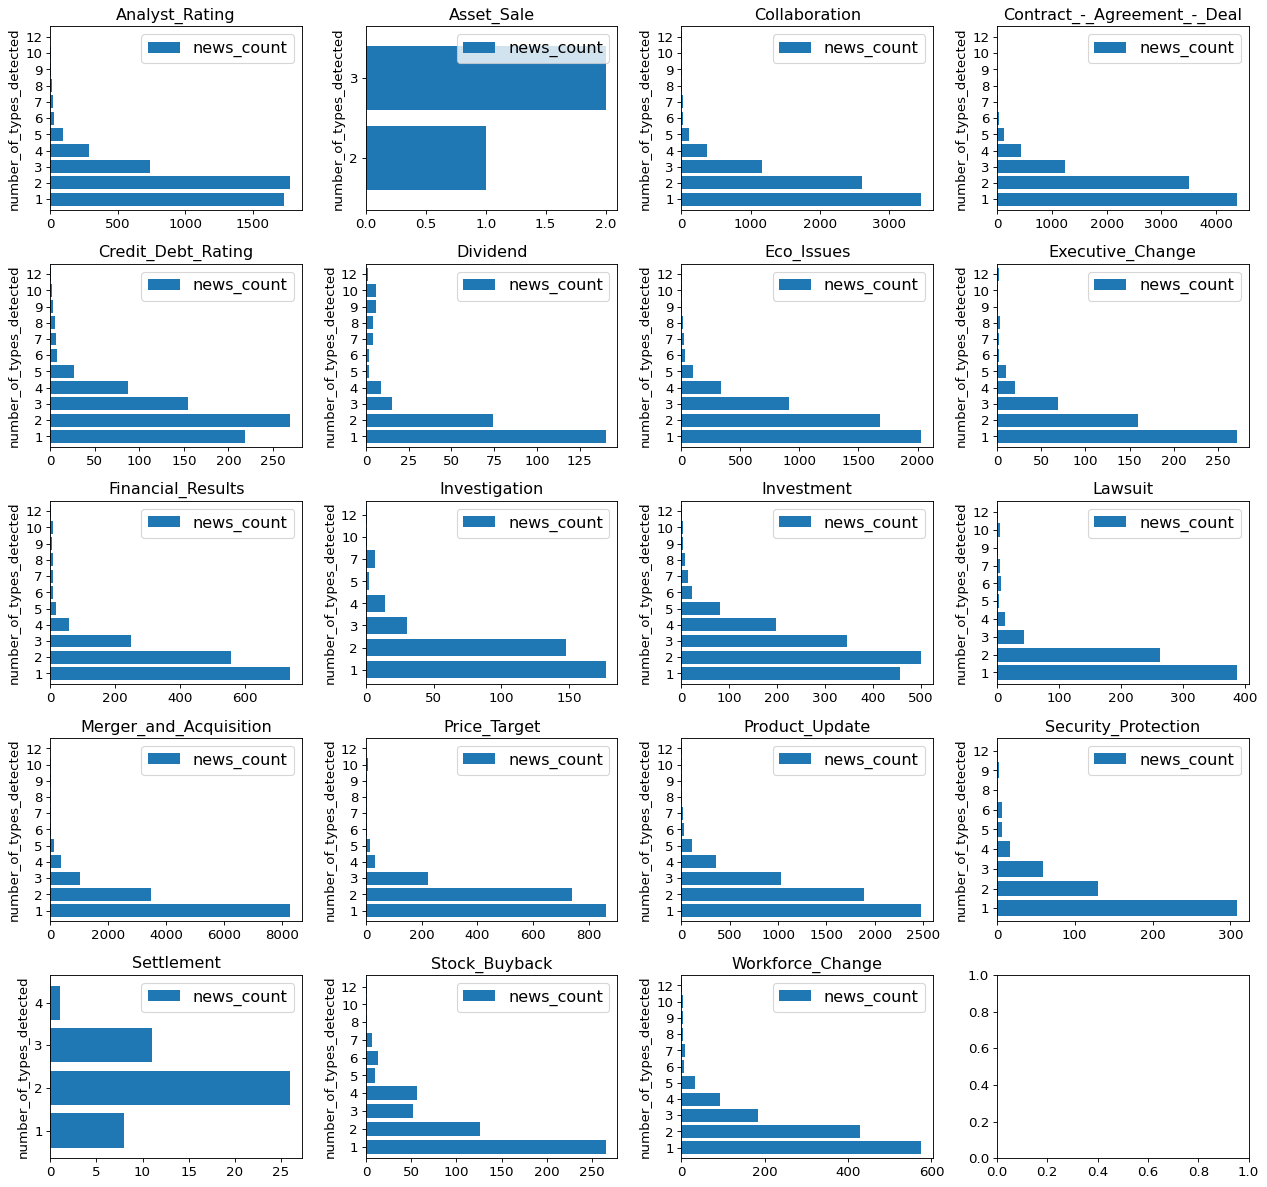

In [432]:
# Один элемент variables - один подграфик
variables = cols_totals_match_count

# Посчитаем количество столбцов и строк с графиками
ncols_plot = 4 # math.floor(len(variables)**0.5)
nrows_plot = math.ceil(len(variables) / ncols_plot)

print('nrows_plot:', nrows_plot, 
      'ncols_plot:', ncols_plot)

# Зададим размер пространства для одного подграфика
subplot_size_width = 4
subplot_size_height = 3

# Зададим расстояние для графика в целом
plot_size_inches_width = ncols_plot * subplot_size_width
plot_size_inches_height = nrows_plot * subplot_size_height

fig, axes = plt.subplots(nrows=nrows_plot, ncols=ncols_plot)
fig.set_size_inches(plot_size_inches_width, plot_size_inches_height, forward=True)

for i in range(0, len(variables)):
    # Будем перебирать порядковые номера элементов, подсчитывая позицию графика
    col_pos = i // ncols_plot
    row_pos = i % (nrows_plot - 1)
    print(i, col_pos, row_pos, ';  ', end = '')
    
    # Отрисуем подграфик
    key_words_detection_df[
        (key_words_detection_df['number_of_types_detected'] > 0) &
        (key_words_detection_df[variables[i]] > 0)
    ].groupby(by='number_of_types_detected').agg(
        news_count = ('storyId', 'count')
    ).plot(kind='barh', width=0.8, ax=axes[col_pos,row_pos]); axes[col_pos,row_pos].set_title(variables[i])
    plt.tight_layout()

plt.savefig('Number_of_event_types_detected_for_selected_event_type.png', bbox_inches = "tight")

## Пересечения типов новостей между собой

In [173]:
key_words_detection_df[key_words_detection_df['Analyst_Rating'] > 0]['Analyst_Rating'].mean()

1.4247248887848278

In [224]:
event_types_df = pd.DataFrame(data = [], columns=[])
event_types_list_after_loop
for event_type_now in event_types_list_after_loop:
    event_types_df = event_types_df.append({
        'event_type_1': event_type_now,
        'number_of_news': sum(key_words_detection_df[event_type_now] > 0),
        'number_of_detections': sum(key_words_detection_df[event_type_now]),
        'max_number_of_detection_per_text': max(key_words_detection_df[event_type_now]),
        'mean_number_of_detection_per_text': key_words_detection_df[key_words_detection_df[event_type_now] > 0][event_type_now].mean(),
    }, ignore_index = True)

In [437]:
event_types_df.head(3)

,event_type_1,max_number_of_detection_per_text,mean_number_of_detection_per_text,number_of_detections,number_of_news
0,Analyst_Rating,3.0,1.424725,6085.0,4271.0
1,Asset_Sale,1.0,1.000000,3.0,3.0
2,Collaboration,3.0,1.064879,7862.0,7383.0


In [226]:
import itertools

intersection_event_types = pd.DataFrame(data = [], columns=["event_type_1", "event_type_2", "ovelapped_news_number"])

for each in itertools.permutations(cols_totals_match_count,2):
    news_number_now = key_words_detection_df[
        (key_words_detection_df[each[0]] > 0) &
        (key_words_detection_df[each[1]] > 0)
    ].shape[0]
    
    intersection_event_types = intersection_event_types.append({
        "event_type_1": each[0],
        "event_type_2": each[1],
        "ovelapped_news_number": news_number_now
    }, ignore_index = True)

In [228]:
intersection_event_types.sort_values(by='ovelapped_news_number', ascending=False).head(6)

,event_type_1,event_type_2,ovelapped_news_number
219,Merger_and_Acquisition,Contract_-_Agreement_-_Deal,2451
65,Contract_-_Agreement_-_Deal,Merger_and_Acquisition,2451
38,Collaboration,Contract_-_Agreement_-_Deal,1630
56,Contract_-_Agreement_-_Deal,Collaboration,1630
254,Product_Update,Collaboration,1459
49,Collaboration,Product_Update,1459


In [229]:
# Добавим информацию про event_type_1 типа количества новостей по теме
intersection_event_types = pd.merge(intersection_event_types, event_types_df, how="left", on='event_type_1').sort_values(by='ovelapped_news_number', ascending=False)
# Посчитаем долю пересечённых новостей для каждого event_type
intersection_event_types['proportion_of_overlapped_news'] = intersection_event_types['ovelapped_news_number'] / intersection_event_types['number_of_news']

Text(0.5, 1.0, 'Overlapped news number per one pair of event-types')

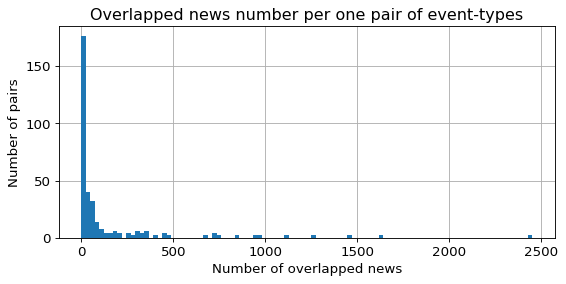

In [252]:
intersection_event_types['ovelapped_news_number'].hist(bins=100)
plt.xlabel('Number of overlapped news')
plt.ylabel('Number of pairs')
plt.title('Overlapped news number per one pair of event-types')

Text(0.5, 1.0, 'Histogram of overlapped news proportion values')

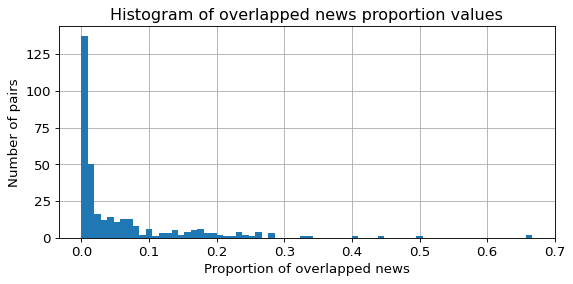

In [251]:
intersection_event_types['proportion_of_overlapped_news'].hist(bins=70)
plt.xlabel('Proportion of overlapped news')
plt.ylabel('Number of pairs')
plt.title('Histogram of overlapped news proportion values')

<AxesSubplot:xlabel='proportion_of_overlapped_news', ylabel='number_of_news'>

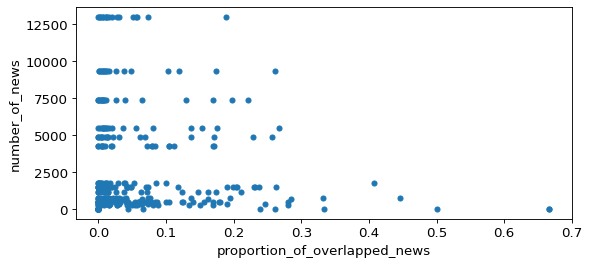

In [246]:
intersection_event_types.plot(x='proportion_of_overlapped_news', y='number_of_news', kind='scatter')

In [263]:
intersection_event_types.loc[110]

event_type_1                            Eco_Issues
event_type_2                         Collaboration
ovelapped_news_number                         1252
max_number_of_detection_per_text                 6
mean_number_of_detection_per_text          1.17122
number_of_detections                          5705
number_of_news                                4871
proportion_of_overlapped_news             0.257031
Name: 110, dtype: object

In [260]:
intersection_event_types[[
    'number_of_news', 'event_type_1', 'event_type_2',
    'ovelapped_news_number', 'proportion_of_overlapped_news'
]].sort_values(by='ovelapped_news_number', ascending=False).head(10)

,number_of_news,event_type_1,event_type_2,ovelapped_news_number,proportion_of_overlapped_news
219,12978.0,Merger_and_Acquisition,Contract_-_Agreement_-_Deal,2451,0.188858
65,9361.0,Contract_-_Agreement_-_Deal,Merger_and_Acquisition,2451,0.261831
38,7383.0,Collaboration,Contract_-_Agreement_-_Deal,1630,0.220777
56,9361.0,Contract_-_Agreement_-_Deal,Collaboration,1630,0.174127
254,5476.0,Product_Update,Collaboration,1459,0.266435
49,7383.0,Collaboration,Product_Update,1459,0.197616
110,4871.0,Eco_Issues,Collaboration,1252,0.257031
41,7383.0,Collaboration,Eco_Issues,1252,0.169579
111,4871.0,Eco_Issues,Contract_-_Agreement_-_Deal,1116,0.229111
59,9361.0,Contract_-_Agreement_-_Deal,Eco_Issues,1116,0.119218


In [ ]:
# Графовый анализ?

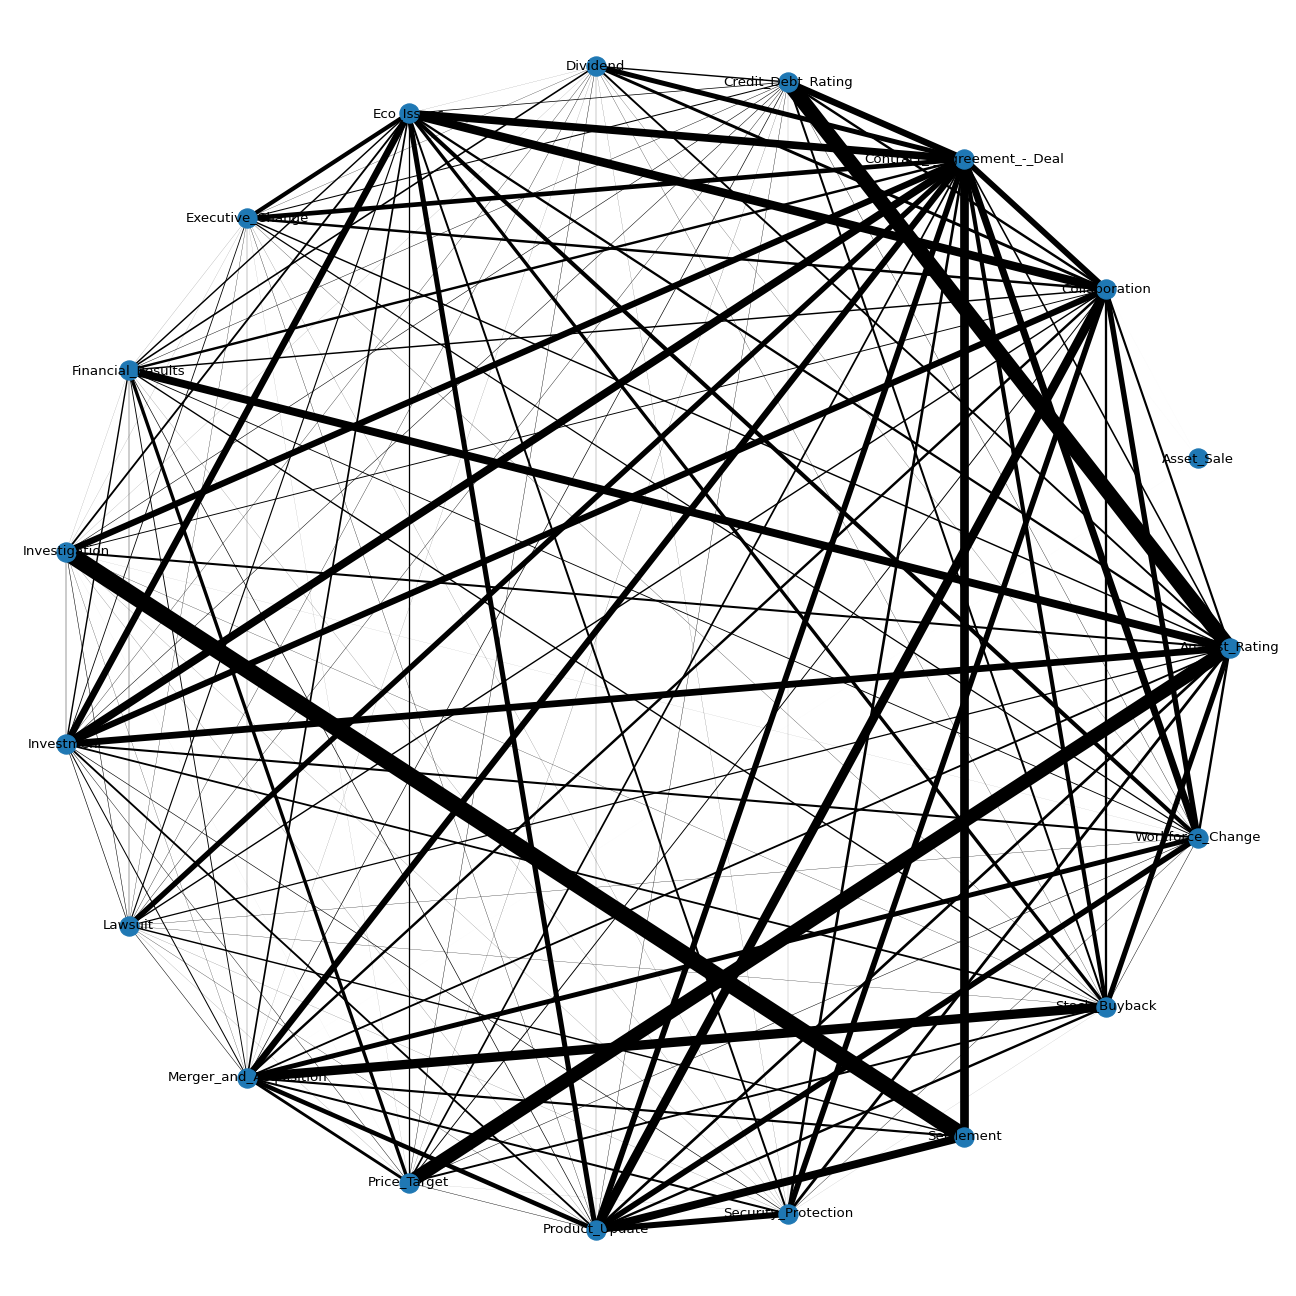

In [553]:
import networkx as nx

rcParams['figure.figsize'] = [16, 16]

graph = nx.Graph()

#
for i in range(0, len(intersection_event_types)):
    graph.add_edge(intersection_event_types.loc[i, 'event_type_1'],
                   intersection_event_types.loc[i, 'event_type_2'],
                   weight=intersection_event_types.loc[i, 'proportion_of_overlapped_news'] * 30) # .loc[i, 'ovelapped_news_number']/200

#
edges = graph.edges()
edges_weight_list = [graph[u][v]['weight'] for u,v in edges]


#
nx.draw_circular(graph, with_labels = True, width = edges_weight_list) 
plt.savefig('Network_event_types_overlapping.png', bbox_inches = "tight")

rcParams['figure.figsize'] = [8, 3.5]

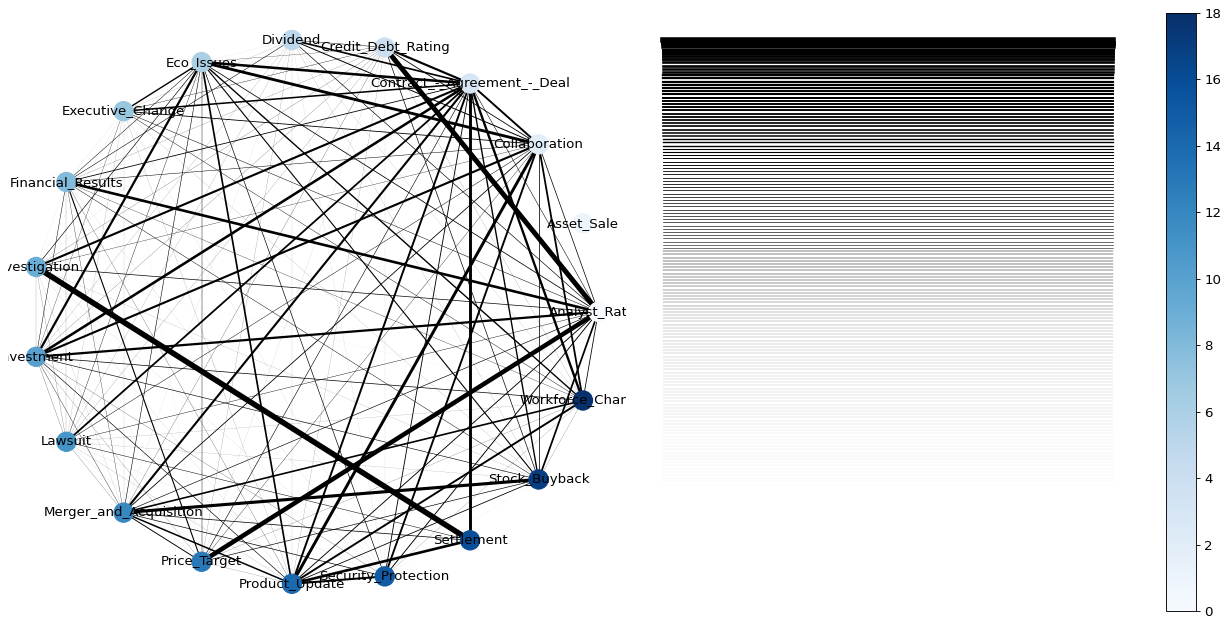

In [576]:
import networkx as nx
rcParams['figure.figsize'] = [16, 8]

plt.subplot(1, 2, 1)
graph = nx.Graph()

for i in range(0, len(intersection_event_types)):
    graph.add_edge(intersection_event_types.loc[i, 'event_type_1'],
                   intersection_event_types.loc[i, 'event_type_2'],
                   weight=intersection_event_types.loc[i, 'proportion_of_overlapped_news'] * 10)

# graph.add_edge('a','b',weight=6)
# graph.add_edge('a','c',weight=2)
# graph.add_edge('c','d',weight=1)
# graph.add_edge('c','e',weight=7)
# graph.add_edge('c','f',weight=9)
# graph.add_edge('a','d',weight=3)


edges = graph.edges()
edges_weight_list = [graph[u][v]['weight'] for u,v in edges]
n_nodes = graph.number_of_nodes()
pos = nx.circular_layout(graph)
nx.draw_networkx_edges(graph, pos, width = edges_weight_list)
nx.draw_networkx_labels(graph, pos)
mcp = nx.draw_networkx_nodes(graph, pos,
                             node_color=list(range(n_nodes)),
                             cmap='Blues')
limits = plt.axis('off')  # turn of axis


# width lines
plt.subplot(1, 2, 2)
edges_weight_list = sorted(edges_weight_list)
for i, current_weight in enumerate(edges_weight_list):
    x=[0, 1]
    y=[i, i]
    plt.plot(x,y, linewidth=current_weight, color='black')

plt.colorbar(mcp)
limits = plt.axis('off')  # turn of axis
plt.tight_layout()
plt.show()

rcParams['figure.figsize'] = [8, 3.5]

## Функция, возвращающая топ новостей для выбранного типа событий

In [569]:
def query_most_relevant_news_for_selected_event_type(
        event_type_selected, top_n_news=50):
    """
    
    """
    cols = ['storyId', 'versionCreated', 'sourceCode', 'ric', 'story_lang'] + cols_totals_match_count + ['number_of_types_detected', 'headline', 'story_wo_html']

    result = key_words_detection_df[
        (key_words_detection_df['number_of_types_detected'] > 0) &
        (key_words_detection_df[event_type_selected] > 0)
    ][cols].sort_values(by=[
        'number_of_types_detected', event_type_selected, 'versionCreated'
    ], ascending=[
        True, False, True
    ]).head(top_n_news)
    
    
    for event_type_name in cols_totals_match_count:
        col_name = 'my_label_' + event_type_name 
        result[col_name] = ''
    
    return result

In [570]:
query_most_relevant_news_for_selected_event_type(
    event_type_selected='Workforce_Change', 
    top_n_news=5
)

,storyId,versionCreated,sourceCode,ric,story_lang,Analyst_Rating,Asset_Sale,Collaboration,Contract_-_Agreement_-_Deal,Credit_Debt_Rating,...,my_labelInvestigation,my_labelInvestment,my_labelLawsuit,my_labelMerger_and_Acquisition,my_labelPrice_Target,my_labelProduct_Update,my_labelSecurity_Protection,my_labelSettlement,my_labelStock_Buyback,my_labelWorkforce_Change
31217,urn:newsml:reuters.com:20191122:nL8N28254O:2,2019-11-22 18:52:21+00:00,NS:RTRS,VOWG_p.DE,en,0,0,0,0,0,...,,,,,,,,,,
174435,urn:newsml:reuters.com:20200426:nNRAbn151g:1,2020-04-26 08:00:10.390000+00:00,NS:WASHPO,AMZN.OQ,en,0,0,0,0,0,...,,,,,,,,,,
93373,urn:newsml:reuters.com:20200402:nL8N2BQ4Z3:1,2020-05-28 11:17:17+00:00,NS:RTRS,LHAG.DE,en,0,0,0,0,0,...,,,,,,,,,,
42515,urn:newsml:reuters.com:20200630:nNRAc7iwwc:1,2020-06-30 21:35:34.686000+00:00,NS:ASSOPR,ADSGn.DE,en,0,0,0,0,0,...,,,,,,,,,,
110473,urn:newsml:reuters.com:20200805:nL1N2F726A:2,2020-08-05 20:22:06+00:00,NS:RTRS,AAPL.OQ,en,0,0,0,0,0,...,,,,,,,,,,


In [586]:
for event_type_name in cols_totals_match_count:
    folder_for_file = path_project_folder + folder_name_for_labelling
    name_for_file = 'for_labelling_' + event_type_name + '.xlsx'
    total_file_path = folder_for_file + name_for_file
    if name_for_file in os.listdir(path_project_folder + folder_name_for_labelling):
        print('Already Exist', total_file_path,)
        pass
    else: 
        query_most_relevant_news_for_selected_event_type(
            event_type_selected=event_type_name, 
            top_n_news=100
        ).to_excel(total_file_path)
        print('Created      ', total_file_path,)

C:/DAN/t_systems/trade_project/for_labelling/for_labelling_Analyst_Rating.xlsx   Already Exist
C:/DAN/t_systems/trade_project/for_labelling/for_labelling_Asset_Sale.xlsx   Already Exist
C:/DAN/t_systems/trade_project/for_labelling/for_labelling_Collaboration.xlsx   Already Exist
C:/DAN/t_systems/trade_project/for_labelling/for_labelling_Contract_-_Agreement_-_Deal.xlsx   Already Exist
C:/DAN/t_systems/trade_project/for_labelling/for_labelling_Credit_Debt_Rating.xlsx   Already Exist
C:/DAN/t_systems/trade_project/for_labelling/for_labelling_Dividend.xlsx   Already Exist
C:/DAN/t_systems/trade_project/for_labelling/for_labelling_Eco_Issues.xlsx   Already Exist
C:/DAN/t_systems/trade_project/for_labelling/for_labelling_Executive_Change.xlsx   Already Exist
C:/DAN/t_systems/trade_project/for_labelling/for_labelling_Financial_Results.xlsx   Already Exist
C:/DAN/t_systems/trade_project/for_labelling/for_labelling_Investigation.xlsx   Already Exist
C:/DAN/t_systems/trade_project/for_labelling

['for_labelling_Analyst_Rating.xlsx',
 'for_labelling_Asset_Sale.xlsx',
 'for_labelling_Collaboration.xlsx',
 'for_labelling_Contract_-_Agreement_-_Deal.xlsx',
 'for_labelling_Credit_Debt_Rating.xlsx',
 'for_labelling_Dividend.xlsx',
 'for_labelling_Eco_Issues.xlsx',
 'for_labelling_Executive_Change.xlsx',
 'for_labelling_Financial_Results.xlsx',
 'for_labelling_Investigation.xlsx',
 'for_labelling_Investment.xlsx',
 'for_labelling_Lawsuit.xlsx',
 'for_labelling_Merger_and_Acquisition.xlsx',
 'for_labelling_Price_Target.xlsx',
 'for_labelling_Product_Update.xlsx',
 'for_labelling_Security_Protection.xlsx',
 'for_labelling_Settlement.xlsx',
 'for_labelling_Stock_Buyback.xlsx',
 'for_labelling_Workforce_Change.xlsx']